# Model validation

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99' # NOTE: jax preallocates GPU (default 75%)
# from jax.config import config; config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util, pmap
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# mlflow.set_experiment("Model Validation")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


## Render model

# CONFIG
{'mesh_size': array([128, 128, 128]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_meshes': True, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0], 'init_mesh': ['{\\delta}_L', None, None]}, 'fourier': False, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [5.0, 5.0, 5.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.62832 h/Mpc
mean_gxy_density: 0.125 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

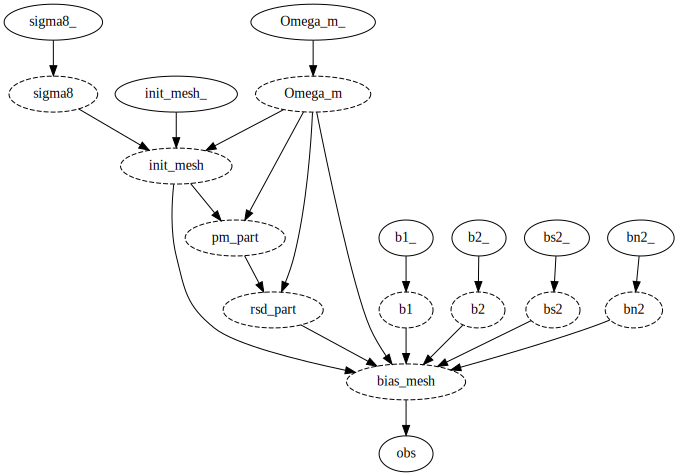

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn, get_cosmology
from montecosmo.models import print_config, get_prior_loc, default_config as config
# Build and render model
config.update(a_lpt=0.5, a_obs=0.5, mesh_size=128*np.ones(3, dtype=int), box_size=640*np.ones(3), 
            #   trace_reparam=True, trace_meshes=True, fourier=False) # 256 requires 20Gio, 1000
              trace_reparam=True, trace_meshes=True, fourier=False) # 256 requires 20Gio, 1000
# config['prior_config']['b2'][1] = 0
# config['prior_config']['b1'][1] = 1
model = partial(pmrsd_model, **config)
print_config(model)
numpyro.render_model(model=model, render_params=True) # filename="model_DAG.png"

## Simulate fiducial

In [3]:
# Get fiducial parameters
param_fn = get_param_fn(**config)
fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_loc(model)))
fiduc_trace = get_simulator(fiduc_model)(rng_seed=0)
fiduc_cosmo = get_cosmology(**fiduc_trace)
print(f"Fiducial {fiduc_cosmo}")

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2621 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


## Power spectra

In [4]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get and vectorize relevant functionals
multipoles = [0,2,4]
pk_fn = get_pk_fn(multipoles=multipoles, **config)

# Get meshes from model trace particles. Must compensate for CIC painting convolution
zeros_mesh = jnp.zeros(config['mesh_size'])
pm_mesh = vmap(cic_paint, in_axes=(None,0))(zeros_mesh, fiduc_trace['pm_part'][...,:3])
# pm_pos = fiduc_trace['pm_part'][...,:3]
# pm_mesh = jnp.zeros((22, *config['mesh_size']))
# for i in range(5):
#     pm_mesh = pm_mesh.at[4*i:4*(i+1)].set(vmap(cic_paint, in_axes=(None,0))(zeros_mesh, pm_pos[4*i:4*(i+1),:,:3]))
# pm_mesh = pm_mesh.at[-2:].set(vmap(cic_paint, in_axes=(None,0))(zeros_mesh, pm_pos[-2:,:,:3]))

rsd_mesh = cic_paint(zeros_mesh, fiduc_trace['rsd_part'][:,:3])

# Compute power spectra
pk_init = pk_fn(fiduc_trace['init_mesh'])
pk_pm = vmap(pk_fn)(vmap(compensate_cic)(pm_mesh))
pk_rsd = pk_fn(compensate_cic(rsd_mesh))
pk_bias = pk_fn(compensate_cic(fiduc_trace['bias_mesh']))
# pk_obs = pk_fn(compensate_cic(fiduc_trace['obs_mesh']))
pk_lin_init = jnp.array([pk_init[0], linear_pk_interp(fiduc_cosmo)(pk_init[0])])
pk_lin_obs = jnp.array([pk_init[0], linear_pk_interp(fiduc_cosmo, a=config['a_obs'])(pk_init[0])])

from montecosmo.metrics import kaiser_formula
from montecosmo.bricks import apply_kaiser_bias

fiduc_kaiser_bias = condition(apply_kaiser_bias, {'b': 1+fiduc_trace['b1']})
kaiser_mesh = fiduc_kaiser_bias(fiduc_cosmo, config['a_obs'], fiduc_trace['init_mesh'])
pk_kaiser_bias = pk_fn(kaiser_mesh)
pk_kaiser_lin = kaiser_formula(fiduc_cosmo, config['a_obs'], pk_lin_init, 1+fiduc_trace['b1'], multipoles)
# pk_kaiser_init = kaiser_formula(fiduc_cosmo, config['a_obs'], pk_init, 1+fiduc_trace['b1'], multipoles)

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

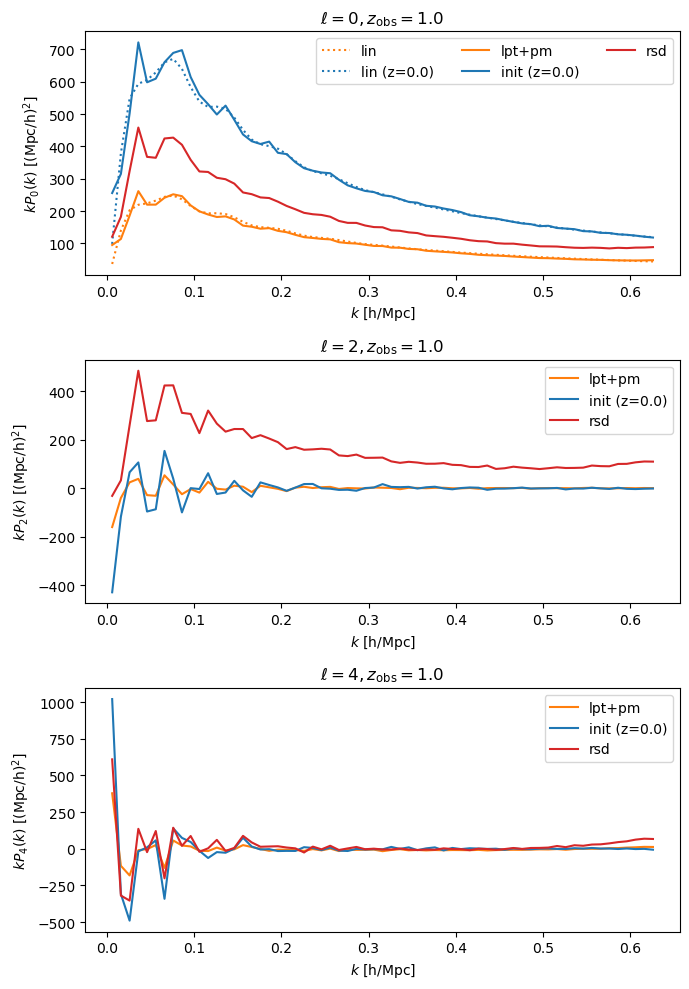

In [7]:
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    if multipole==0:
        plot_fn(pk_lin_obs, 'C1:', label=f"lin")
    if multipole==0:
        plot_fn(pk_lin_init, 'C0:', label=f"lin (z={1/1-1:.1f})")

    plot_fn(pk_pm[-1], 'C1', label=f"lpt+pm")    
    for pk in pk_pm[:-1]:
        plot_fn(pk, 'C1', alpha=0.2)
    plot_fn(pk_init, 'C0', label=f"init (z={1/1-1:.1f})")
    plot_fn(pk_rsd, 'C3', label=f"rsd")

    if multipole==0: plt.legend(ncols=3, loc='upper right')
    else: plt.legend(loc='upper right')
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_rsd{rsd:b}_smooth{smooth:b}.svg")
plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();

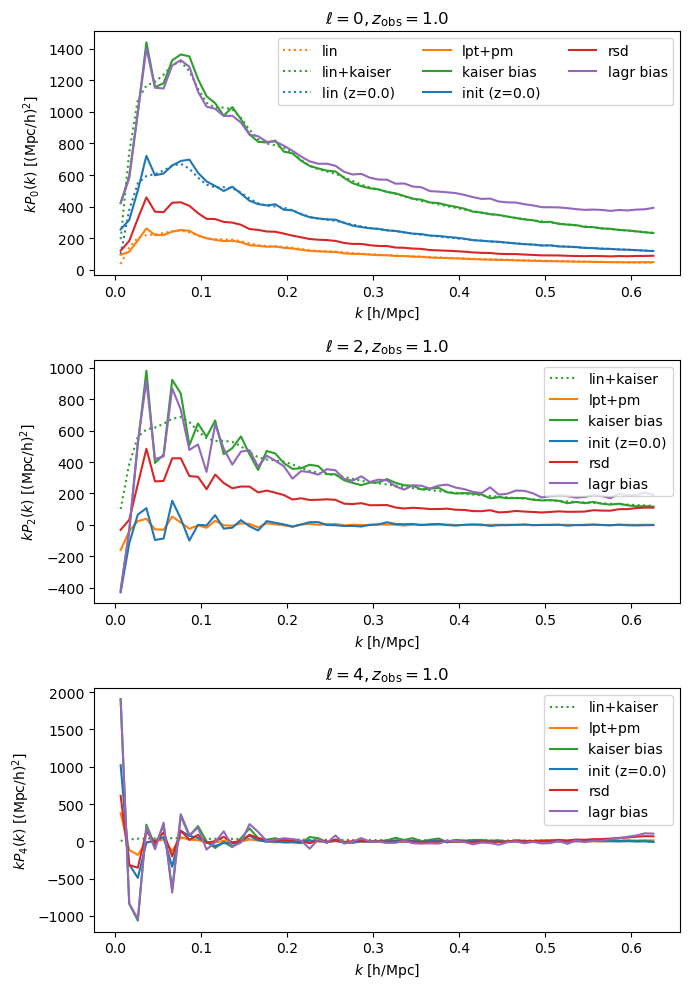

In [ ]:
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    if multipole==0:
        plot_fn(pk_lin_obs, 'C1:', label=f"lin")
    plot_fn(pk_kaiser_lin, 'C2:', label=f"lin+kaiser")
    if multipole==0:
        plot_fn(pk_lin_init, 'C0:', label=f"lin (z={1/1-1:.1f})")

    # plot_fn(pk_kaiser_init, 'C2--', label=f"init+kaiser")
    plot_fn(pk_pm[-1], 'C1', label=f"lpt+pm")    
    for pk in pk_pm[:-1]:
        plot_fn(pk, 'C1', alpha=0.2)
    plot_fn(pk_kaiser_bias, 'C2', label=f"kaiser bias ")
    plot_fn(pk_init, 'C0', label=f"init (z={1/1-1:.1f})")
    plot_fn(pk_rsd, 'C3', label=f"rsd")
    plot_fn(pk_bias, 'C4', label=f"lagr bias")
    # plot_fn(pk_obs, 'C5', label=f"obs")

    if multipole==0: plt.legend(ncols=3, loc='upper right')
    else: plt.legend(loc='upper right')
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_rsd{rsd:b}_smooth{smooth:b}.svg")
plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();

## Bias effects

In [18]:
b_vals = [-3,0,3]
# b_names = ['b2','bs2','bn2']
b_names = ['b2']
# b_namlabvals = [['b2=bs2=bn2', '$b_2=b_{s^2}=b_{\nabla^2}$', 0]]
b_namlabvals = []
for b_nam in b_names:
    for b_val in b_vals:
        b_lab, b_mean, b_std = config['prior_config'][b_nam]
        b_lab = '$'+b_lab+'$'
        b_val = (b_val - b_mean) / b_std
        b_namlabvals.append([b_nam+'_', b_lab, b_val])

pk_biases = []
bias_comp_meshes = []
bias_poses = []
bias_weights = []
for b_nam, _, b_val in b_namlabvals:
    cond_params = dict(fiduc_trace)
    cond_params[b_nam] = b_val
    params = get_simulator(condition(model, cond_params))(rng_seed=0)
    # bias_comp_mesh = compensate_cic(params['bias_mesh'])
    bias_comp_mesh = params['bias_mesh']
    bias_comp_meshes.append(bias_comp_mesh)
    # pk_biases.append(pk_fn(bias_comp_mesh))
    # bias_poses.append(params['rsd_part'][...,:3])
    # bias_weights.append(params['lbe_weights'])
# pk_biases = jnp.array(pk_biases)
bias_comp_meshes = jnp.array(bias_comp_meshes)
# bias_poses = jnp.array(bias_poses)
# bias_weights = jnp.array(bias_weights)
# pickle_dump(pk_biases, './pk_biases_uncomp.p')
pickle_dump(bias_comp_meshes, './bias_meshes_uncomp.p')
# pickle_dump(fiduc_trace['rsd_part'][...,:3], './bias_pos.p')
# pickle_dump(fiduc_trace['lbe_weights'], './bias_weights.p')

In [18]:
# pickle_dump(bias_poses, './bias_poses.p')
# pickle_dump(bias_weights, './bias_weights.p')
from jaxpm.growth import growth_factor, growth_rate
init_mesh_obs = growth_factor(fiduc_cosmo, jnp.atleast_1d(config['a_obs'])) * fiduc_trace['init_mesh']
pickle_dump(init_mesh_obs, './init_mesh_obs.p')

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


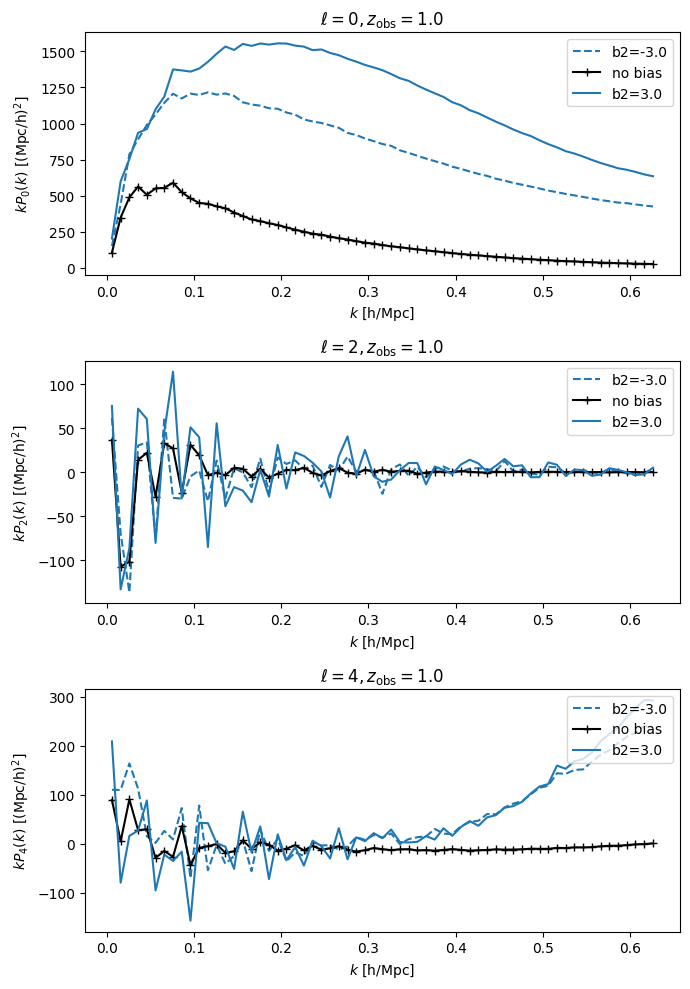

In [31]:
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    colors = ['k+-','C0','C1','C2']
    i_color = 0
    format = colors[i_color]
    for pk, (b_nam, b_lab, b_val), in zip(pk_biases, b_namlabvals):
        if b_val==0:
            label = "no bias"
            format = 'k+-'
        else:
            _, b_mean, b_std = config['prior_config'][b_nam[:-1]]
            label = b_nam[:-1]+f"={b_val*b_std+b_mean:.1f}"
            if b_val<0:
                i_color+=1
                format = colors[i_color]+'--'
            else:
                format = colors[i_color]

        k_nyquist = jnp.pi * jnp.min(config['mesh_size'] / config['box_size'])
        plot_fn(pk, format, label=label)
        # pksmooth = np.copy(pk)
        # pksmooth[1] = pksmooth[1] * (jnp.exp(-.5 * pksmooth[0]**2 / k_nyquist**2))**2
        # plot_fn(pksmooth, format, label=label)

    plt.legend(loc='upper right'), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_biases_rsd{rsd:b}_smooth{smooth:b}.svg")
plt.show();

In [33]:
pickle_dump(bias_comp_meshes, "bias_meshes_256_1280_rsd0_smooth0_uncomp.p")

## Validation 

In [13]:
# %pip install git+https://github.com/sfschen/ZeNBu -q
import numpy as np
from matplotlib import pyplot as plt

def get_pt(kv, klin, pklin, f=None, cutoff=np.pi):
    """
    Return Zeldovich prediction.

    Parameters
    ----------
    kv : array
        Output k.

    klin : array
        Input linear k.

    pklin : array
        Output P(k).

    f : float
        Growth rate.
    """
    from ZeNBu.zenbu import Zenbu
    from ZeNBu.zenbu_rsd import Zenbu_RSD
    if f is None:  # real space
        zobj = Zenbu(klin, pklin, jn=15, N=3000, cutoff=cutoff)
        zobj.make_ptable(kvec=kv)
        tmp = zobj.pktable.T[1:]  # first is k, drop it
        pktable = np.zeros((14,) + tmp.shape[1:], dtype='f8')
        pktable[:10, ...] = tmp[:10, ...]
        pktable[10:, ...] = -kv[np.newaxis, :]**2 * tmp[[0, 1, 3, 6], ...]  # nabla
        pktable = pktable[:, None, :]
    else:
        lpt = Zenbu_RSD(klin, pklin, jn=15, N=2500, cutoff=cutoff)
        lpt.make_pltable(f, kv=kv, nmax=8, ngauss=3)

        p0table = lpt.p0ktable
        p2table = lpt.p2ktable
        p4table = lpt.p4ktable

        pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
        pktable[:, 0, :] = p0table
        pktable[:, 1, :] = p2table
        pktable[:, 2, :] = p4table
        pktable = pktable.T

    return pktable


def get_pk(pktable, b1=1, b2=0., bs2=0., bk2=0.):

    """Return galaxy power spectrum prediction."""
    pktable = pktable[:14]
    bias_monomials = np.array([1,
                                2*b1, b1**2,
                                b2, b1*b2, 0.25*b2**2,
                                2*bs2, 2*b1*bs2, b2*bs2, bs2**2,
                                2*bk2, 2*bk2*b1, bk2*b2, 2*bk2*bs2])

    # sum for each multipole and combine into pk
    return np.sum(bias_monomials[:, None, None] * pktable, axis=0)

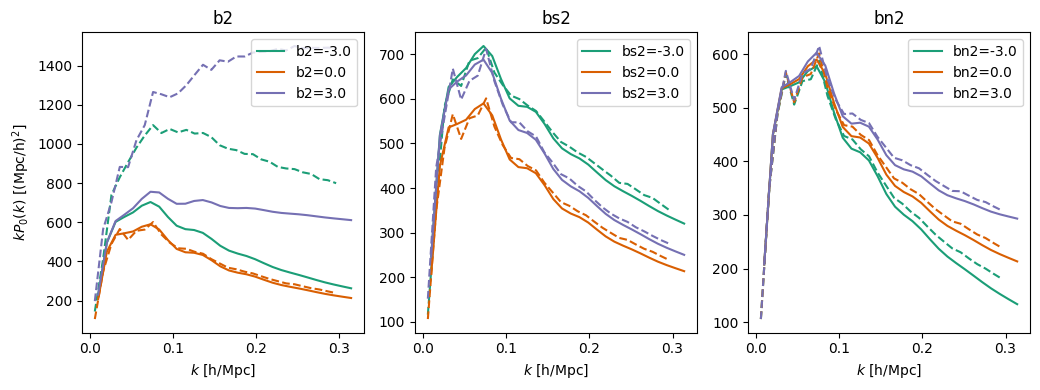

In [14]:
# kv = np.linspace(0.01, pk_biases[0,0,-1], 30)
kv = np.linspace(0.01, 0.314, 30)
klin = np.logspace(-3., 2, 1000)

# from cosmoprimo.fiducial import DESI
# cosmo = DESI()
# z = 1.
# f = cosmo.growth_rate(z)
# pklin = cosmo.get_fourier().pk_interpolator()(k=klin, z=z)
from jaxpm.growth import growth_factor, growth_rate
from montecosmo.bricks import linear_pk_interp
from jaxpm.painting import cic_compensation, compensate_cic

f = growth_rate(fiduc_cosmo, jnp.atleast_1d(config['a_obs']))
pklin = linear_pk_interp(fiduc_cosmo, config['a_obs'], n_interp=256)(klin)
k_nyquist = jnp.pi * jnp.min(config['mesh_size'] / config['box_size'])
# if smooth:
#     pklin = pklin * jnp.exp(- (klin / k_nyquist)**2)
#     print("smooth")
# pklin = pklin / cic_compensation(klin / (config['mesh_size'] / config['box_size'])[0])**2

plt.figure(figsize=(lambda h:(3*h*7/6,(3 if rsd else 4/3)*h))(3))
if rsd:  # if RSD, k^2 not modelled?
    ells = (0, 2, 4)
    pktable = get_pt(kv, klin, pklin, f, cutoff=k_nyquist)
else:
    ells = (0,)
    pktable = get_pt(kv, klin, pklin, f=None, cutoff=k_nyquist)

biases = [('b2', np.linspace(-3., 3., 3)), ('bs2', np.linspace(-3., 3., 3)), ('bn2', np.linspace(-3., 3., 3))]
# biases = [('b2', np.linspace(-2., 2., 3)), ('bs2', np.linspace(-2., 2., 3)), ('bn2', np.linspace(-2., 2., 3))]
for i_param, (param, values) in enumerate(biases):
    cmap = plt.get_cmap('Dark2')
    for i_value, value in enumerate(values):
        if param=='bn2': params = {'bk2':-value} # NOTE: bk2 = -bnl
        else: params = {param:value}
        poles = get_pk(pktable, b1=0.5, **params)
        color = cmap(i_value / 7)
        for ill, ell in enumerate(ells):
            plt.subplot(len(ells),len(biases),i_param+1+ill*len(biases))
            plt.plot(kv, kv * poles[ill], color=color, label=f"{param}={value:.1f}")
            
            plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[ill+1], *args, **kwargs)
            # plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[ill+1] * jnp.exp(- (pk[0] / k_nyquist)**2), *args, **kwargs)
            plot_fn(pk_biases[3*i_param+i_value,:,:30], '--', color=color)
            # if value<0:
            #     plot_fn(pk_biases[1+2*i_param], '--', color=color)
            # elif value>0:
            #     plot_fn(pk_biases[2+2*i_param], '--', color=color)
            # else:
            #     plot_fn(pk_biases[0], '--', color=color)
            if ill==0: 
                plt.title(f"{param}"), plt.legend(loc='upper right'), 
                # plt.ylim(0, 2000)
            # if ill==1: plt.ylim(0, 800)
            # if ill==2: plt.ylim(-800, 800)
            if i_param==0: plt.ylabel(f"$k P_{ell}(k)$ [(Mpc/h)$^2$]")
            # if i_param==0: plt.ylabel(f"$P_{ell}(k)$ [(Mpc/h)$^3$]")
            if ill==len(ells)-1: plt.xlabel("$k$ [h/Mpc]")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_biasvalid_rsd{rsd:b}_smooth{smooth:b}_{int(config['box_size'][0])}.svg")
plt.show()

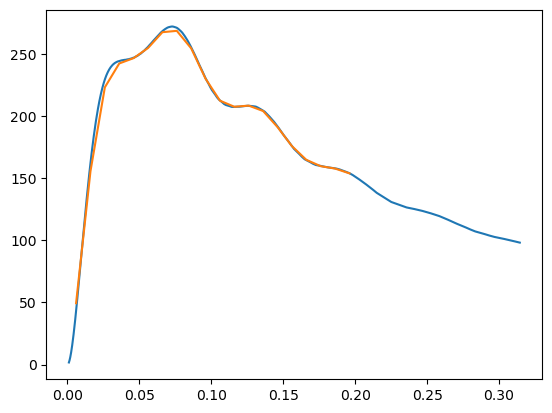

In [34]:
from jaxpm.growth import growth_factor, growth_rate

kmax = 500
plt.plot(klin[:kmax], klin[:kmax]*pklin[:kmax])
plt.plot(pk_init[0], pk_init[0]*pk_init[1]*growth_factor(fiduc_cosmo, jnp.array([config['a_obs']]))**2 )

## Cubes

In [9]:
from matplotlib.colors import Normalize
def plot_cube_vox(mesh, mesh_size, box_size, cmap='viridis', vmin=None, vmax=None, **config):
    xx, yy, zz = np.indices(mesh_size)
    cube = (xx==mesh_size[0]-1) | (yy==0) | (zz==mesh_size[2]-1)
    cube = cube | (xx==0) | (yy==mesh_size[1]-1)
    xx, yy, zz = np.indices(mesh_size+1) * (box_size/mesh_size)[:,None,None,None]
    cmap = plt.get_cmap(cmap)
    ax3d = plt.gca()

    norm = Normalize(vmin, vmax)
    if vmin is None and vmax is None:
        norm.autoscale(mesh)
    m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    faces = ax3d.voxels(xx, yy, zz, cube, facecolors=cmap(norm(mesh)), shade=False)
    ax3d.set_xlabel("$x$ [Mpc/h]"), ax3d.set_ylabel("$y$ [Mpc/h]"), ax3d.set_zlabel("$z$ [Mpc/h]")
    return m

def plot_cube_scat(mesh, mesh_size, box_size, cmap='viridis', alpha=None, vmin=None, vmax=None, **config):
    plotconfig = dict(cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    xx, yy, zz = np.indices(mesh_size)
    cube = (xx==mesh_size[0]-1) | (yy==0) | (zz==mesh_size[2]-1)
    # cube = cube | (xx==0) | (yy==mesh_size[1]-1)
    # cube = (xx>=mesh_size[0]-1-5) | (yy<=0+5) | (zz>=mesh_size[2]-1-5)
    # cube = cube | (xx<=0+5) | (yy>=mesh_size[1]-1-5)
    # cube = cube & (mesh > vmin)
    xx, yy, zz = (np.indices(mesh_size) * (box_size/mesh_size)[:,None,None,None])[:,cube]
    ax3d = plt.gca()

    p3d = ax3d.scatter(xx, yy, zz, marker =".", c=mesh[cube], alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)
    ax3d.set_xlabel("$x$ [Mpc/h]"), ax3d.set_ylabel("$y$ [Mpc/h]"), ax3d.set_zlabel("$z$ [Mpc/h]")
    # ax3d.set_xlabel("$x\; [\\text{Mpc}/h]$"), ax3d.set_ylabel("$y\; [\\text{Mpc}/h]$"), ax3d.set_zlabel("$z\; [\\text{Mpc}/h]$")
    # ax3d.set_xlabel("$x\; [\\textrm{Mpc}/h]$"), ax3d.set_ylabel("$y\; [\\textrm{Mpc}/h]$"), ax3d.set_zlabel("$z\; [\\textrm{Mpc}/h]$")
    return p3d, cube

def plot_cube_surf(ax3d, mesh, mesh_size, box_size, levels=None, cmap='viridis', alpha=None, vmin=None, vmax=None, **config):
    xx, yy, zz = (np.indices(mesh_size) * (box_size/mesh_size)[:,None,None,None])
    plotconfig = dict(cmap=cmap, vmin=vmin, vmax=vmax, levels=levels, alpha=alpha)
    
    p3dx = ax3d.contourf(mesh[-1], yy[-1], zz[-1], zdir='x', offset=xx.max(), **plotconfig)
    p3dy = ax3d.contourf(xx[:,0], mesh[:,0], zz[:,0], zdir='y', offset=0, **plotconfig)
    p3dz = ax3d.contourf(xx[:,:,-1], yy[:,:,-1], mesh[:,:,-1], zdir='z', offset=zz.max(), **plotconfig)
    ax3d.set(xlim=[xx.min(), xx.max()], ylim=[yy.min(), yy.max()], zlim=[zz.min(), zz.max()])
    ax3d.set_xlabel("$x$ [Mpc/h]"), ax3d.set_ylabel("$y$ [Mpc/h]"), ax3d.set_zlabel("$z$ [Mpc/h]")
    return p3dx, p3dy, p3dz

In [11]:
from matplotlib import animation
from jaxpm.growth import growth_factor, growth_rate
init_zlpt = 1+growth_factor(fiduc_cosmo, jnp.atleast_1d(config['a_lpt'])) * fiduc_trace['init_mesh']
obs_mesh_comp = fiduc_trace['obs_mesh'] / (config['galaxy_density'] * config['box_size'].prod() / config['mesh_size'].prod())

meshes = jnp.array([init_zlpt, *pm_mesh, fiduc_trace['bias_prersd_mesh'], fiduc_trace['bias_mesh'], obs_mesh_comp])#[:-1]
# logmax = lambda x: jnp.log(jnp.maximum(x, 0.1))
# meshes = logmax(meshes)
snapshots = np.linspace(config['a_lpt'], config['a_obs'], len(pm_mesh))
titles_pm = ['lpt+pm'+f", z={1/a-1:.1f}" for a in snapshots]
# titles_pm[0] = 'lpt+pm, z=10.'
titles = [f"init, z={1/config['a_lpt']-1:.1f}", 
          *titles_pm, 
          f"bias, z={1/config['a_obs']-1:.1f}", 
          f"rsd, z={1/config['a_obs']-1:.1f}", 
          f"obs, z={1/config['a_obs']-1:.1f}",]#[:-1]
# i_reps = np.cumsum([20, *([10]+(len(pm_mesh)-2)*[1]+[20]), 20, 20, 50], dtype=int)
# i_reps = np.cumsum([10, *([10]+(len(pm_mesh)-2)*[1]+[10]), 10, 10, 30], dtype=int)
# i_reps = np.cumsum([20, *([5]+(len(pm_mesh)-2)*[1]+[20]), 20, 20, 45], dtype=int)
# i_reps = np.cumsum([2, *([2]+(len(pm_mesh)-2)*[1]+[2]), 2, 2, 3], dtype=int)
i_reps = np.cumsum([1, *([1]+(len(pm_mesh)-2)*[1]+[1]), 1, 1, 1], dtype=int)
assert len(i_reps)==len(titles)==len(meshes)
# vmin, vmax = get_vlim(1*1e-3, 1)(meshes)
vmin, vmax = 0, jnp.quantile(meshes, q=1-20/3*1e-3)
# vmin, vmax = None, None

dark_theme = False
plot_fn = plot_cube_surf
theme = theme_switch(dark_theme)
nrows, ncols = 1, 1     

cmap = 'viridis'
plt.figure(figsize=(lambda h:(ncols*h*7/6,nrows*h))(7))
ax3d = plt.subplot(nrows, ncols,1, projection='3d')
plotconfig = dict(cmap=cmap, vmin=vmin, vmax=vmax, levels=50, alpha=1)
p3ds = plot_fn(ax3d, meshes[0], **plotconfig, **config)
# for p3d in p3ds:
#     for coll in p3d.collections: 
#         coll.remove()
# p3d, cube = plot_fn(ax3d, meshes[0], **plotconfig, **config)
title = plt.title(titles[0], fontsize=16)

# Remove some of the grid
ax3d.xaxis.set_pane_color((1,1,1,0))
ax3d.yaxis.set_pane_color((1,1,1,0))
ax3d.zaxis.set_pane_color((1,1,1,0))
# ax3d.xaxis.pane.set_edgecolor((1,1,1,0))
# ax3d.xaxis.pane.fill = False
# plt.axis("off")
ax3d.grid(False)
# plt.colorbar(p3d, location='right').set_label("$1+\delta$")
plt.tight_layout()

def update(i):
    i_toplot_old = -1
    ax3d.view_init(elev=30, azim=-60) # -60
    if i < i_reps[-1]:
        i_toplot = np.digitize(i, i_reps)
        if i_toplot != i_toplot_old:
            p3ds = plot_fn(ax3d, meshes[i_toplot], **plotconfig, **config)
            # p3d.set_array(meshes[i_toplot][cube])
            title.set_text(titles[i_toplot])
        i_toplot_old = i_toplot
    elif i < i_reps[-1] + 90:
        ax3d.view_init(elev=30, azim=-(i-i_reps[-1])-60) # -60
    return plt.gcf(), *p3ds, title

# save_name = f"cube_ms{config['mesh_size'][0]:d}_b1b2_02_dkth{dark_theme:b}_{cmap}"
# # # mlflow.log_figure(plt.gcf(), save_name+".svg")
anim = animation.FuncAnimation(plt.gcf(), update, frames=i_reps[-1], interval=100, blit=True)
plt.close(), 
display(anim)
# anim.save(save_name+".mp4", dpi=200)
# anim.save(save_name+".gif", dpi=200)
# mlflow.log_artifact(save_name+".mp4")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


<Figure size 640x480 with 0 Axes>

(Array(-5.438224, dtype=float32),
 Array(214.82584, dtype=float32),
 Array(1.6684659, dtype=float32),
 Array(4.1496487, dtype=float32),
 Array(10.561503, dtype=float32))

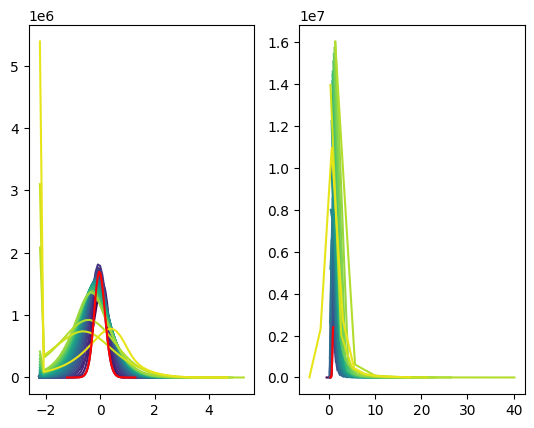

In [21]:
plt.subplot(121)
cmap = plt.get_cmap('viridis')
for i_mesh, mesh in enumerate(meshes):
    hist, bins = jnp.histogram(jnp.log(jnp.maximum(mesh,0.1)), bins=50)
    plt.plot((bins[1:]+bins[:-1])/2, hist, color=cmap(i_mesh/len(meshes)))

# init_zlpt = 1+growth_factor(fiduc_cosmo, jnp.atleast_1d(0.9)) * fiduc_trace['init_mesh']
mesh = meshes[1]
hist, bins = jnp.histogram(jnp.log(jnp.maximum(mesh,0.1)), bins=50)
plt.plot((bins[1:]+bins[:-1])/2, hist, color='r')

max_b = 10
plt.subplot(122)
cmap = plt.get_cmap('viridis')
for i_mesh, mesh in enumerate(meshes):
    hist, bins = jnp.histogram(mesh, bins=50)
    plt.plot(((bins[1:]+bins[:-1])/2)[:max_b], hist[:max_b], color=cmap(i_mesh/len(meshes)))

# init_zlpt = 1+growth_factor(fiduc_cosmo, jnp.atleast_1d(0.9)) * fiduc_trace['init_mesh']
mesh = meshes[1]
hist, bins = jnp.histogram(mesh, bins=50)
plt.plot(((bins[1:]+bins[:-1])/2)[:max_b], hist[:max_b], color='r')
jnp.min(meshes), jnp.max(meshes), jnp.quantile(meshes, q=0.9), jnp.quantile(meshes, q=0.99), jnp.quantile(meshes, q=0.999)

# 128

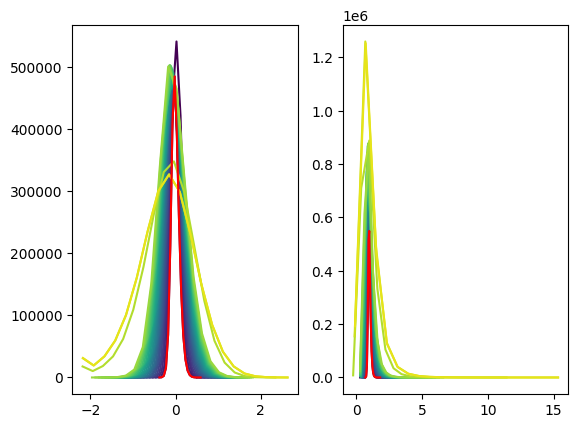

In [ ]:
plt.subplot(121)
cmap = plt.get_cmap('viridis')
for i_mesh, mesh in enumerate(meshes):
    hist, bins = jnp.histogram(jnp.log(jnp.maximum(mesh,0.1)), bins=20)
    plt.plot((bins[1:]+bins[:-1])/2, hist, color=cmap(i_mesh/len(meshes)))

# init_zlpt = 1+growth_factor(fiduc_cosmo, jnp.atleast_1d(0.9)) * fiduc_trace['init_mesh']
mesh = meshes[1]
hist, bins = jnp.histogram(jnp.log(jnp.maximum(mesh,0.1)), bins=20)
plt.plot((bins[1:]+bins[:-1])/2, hist, color='r')

plt.subplot(122)
cmap = plt.get_cmap('viridis')
for i_mesh, mesh in enumerate(meshes):
    hist, bins = jnp.histogram(mesh, bins=20)
    plt.plot((bins[1:]+bins[:-1])/2, hist, color=cmap(i_mesh/len(meshes)))

# init_zlpt = 1+growth_factor(fiduc_cosmo, jnp.atleast_1d(0.9)) * fiduc_trace['init_mesh']
mesh = meshes[1]
hist, bins = jnp.histogram(mesh, bins=20)
plt.plot((bins[1:]+bins[:-1])/2, hist, color='r')